# Date Standardization

Written dates can come in many formats, it may be helpful to be able to standardize them for further processing.

## In this notebook
1. Implement a vanilla Seq2Seq model using a multilayer LSTM.
2. Implement the dot product variant of Luong attention.
3. Experiment with different variations of attention.

## 1. Import, load, and define datasets.

In [1]:
import os
# change this to run on a specific GPU on your machine, indexing starts at 0
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import math
import random
import string
from pathlib import Path
from typing import Callable, List, Tuple

import ipywidgets as widgets
from IPython.display import display, HTML

from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

%matplotlib inline
plt.rcParams["figure.figsize"] = [6, 8]

In [3]:
_DATA_PATH = Path('../data')
_RAW_PATH = _DATA_PATH / 'raw'

In [4]:
def load_dataframes(raw_path):
    df_names = ['train', 'valid', 'test']
    dfs = [pd.read_csv(raw_path/f'{df_name}.csv') for df_name in df_names]
    return dfs


def create_vocab():
    tokens = ['<pad>', '<unk>', '<sos>', '<eos>'] + list(string.printable)
    tok_to_int = {c: i for i, c in enumerate(tokens)}
    int_to_tok = [c for c, i in tok_to_int.items()]
    assert tok_to_int['<pad>'] == 0
    assert tok_to_int['<unk>'] == 1
    assert tok_to_int['<sos>'] == 2
    return tok_to_int, int_to_tok

def build_text_mapper(tok_to_int: dict) -> Callable:
    def mapper(text: str):
        return [tok_to_int['<sos>']] + [tok_to_int.get(c, 1) for c in text] + [tok_to_int['<eos>']]
    return mapper

### Load data and create character -> int mapping

In [5]:
train_df, valid_df, test_df = load_dataframes(_RAW_PATH)
tok_to_int, int_to_tok = create_vocab()

### Define a dataset
Input: 

    encoder input: Noisy date text, i.e. `Saturday December 23, 1834`
    
    decoder input: the standard date text without the last timestep, include <sos> excludes <eos>. 
                   This is only needed when we are training with "teacher forcing". Otherwise the decoder
                   makes predictions on its own without knowing what it the correct answer was for the previous 
                   timestep.
    
output: 

    Standard date text without the first timestep, include <eos>, excludes <sos>
    
The following dataset code is specific to pytorch and may seem a bit convoluted. It just maps an integer index to a single training sample, as described above.

In [43]:
# the model will see sequences of length 32.
# any date shorter than 32 characters will be padded.
_MAXLEN = 32

class DateDataset(utils.data.Dataset):
    """
    Maps an index to a tuple of (inputs, outputs).
    
    Example
    -------
    ds = DateDataset(df, text_mapper)
    ds[0]
    """
    def __init__(self, df: pd.DataFrame, text_mapper: Callable) -> None:
        self.df = df
        self.x_col = 'input'
        self.y_col = 'output'
        self.maxlen = _MAXLEN
        self.pad_val = 0
        self.text_mapper = text_mapper
        
        self._prepare_data()
    
    def _prepare_data(self):
        self.df['encode_text'] = self.df[self.x_col].apply(self.get_tokens, args=('pre',))
        self.df['decode_text'] = self.df[self.y_col].apply(self.get_tokens, args=('post',))
    
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        encode_text = sample.encode_text
        decode_text = sample.decode_text
        return {
            'encode_text': encode_text,
            'decode_text': decode_text[:-1],
            'output': decode_text[1:]
        }
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, text: str, mode: str) -> torch.LongTensor:
        if random.random() < 0.5:
            text = text.lower()
        tokens = self.text_mapper(text)
        tokens = self._pad_sequence(tokens, mode)
        return torch.LongTensor(tokens)
    
    def _pad_sequence(self, seq: List, mode: str) -> List:
        diff = self.maxlen - len(seq)
        if diff < 0:
            raise ValueError('Can not pad a sequence longer than maxlen')
        if mode == 'pre':
            return [self.pad_val] * diff + seq
        elif mode == 'post':
            return seq + [self.pad_val] * diff
        else:
            raise ValueError('mode must be pre or post')


def collate_batch(batch: List):
    """Stack each sample together to make a batch."""
    # text will have shape (B, T)
    encode_text = torch.stack([sample['encode_text'] for sample in batch])
    decode_text = torch.stack([sample['decode_text'] for sample in batch])
    # y, needs to be flat to calculate the loss
    # y shape = (B*T, )
    y = torch.cat([sample['output'] for sample in batch])
    return {'encode_text': encode_text, 'decode_text': decode_text}, y

## Create the datasets

In [44]:
text_mapper = build_text_mapper(tok_to_int)

train_ds = DateDataset(train_df, text_mapper)
valid_ds = DateDataset(valid_df, text_mapper)
test_ds = DateDataset(test_df, text_mapper)

data = DataBunch.create(train_ds, valid_ds, test_ds, bs=256, collate_fn=collate_batch, device=torch.device('cuda:0'))

In [46]:
# visualize one batch
xb, yb = data.one_batch()
print('X_batch')
print(xb)
print('Y_batch')
print(yb)

X_batch
{'encode_text': tensor([[ 0,  0,  0,  ...,  5,  8,  3],
        [ 0,  0,  0,  ..., 13, 13,  3],
        [ 0,  0,  0,  ..., 13, 11,  3],
        ...,
        [ 0,  0,  0,  ...,  7, 11,  3],
        [ 0,  0,  0,  ..., 78, 11,  3],
        [ 0,  0,  0,  ...,  6,  5,  3]]), 'decode_text': tensor([[ 2,  5,  8,  ...,  0,  0,  0],
        [ 2,  5,  8,  ...,  0,  0,  0],
        [ 2,  6,  4,  ...,  0,  0,  0],
        ...,
        [ 2,  5,  9,  ...,  0,  0,  0],
        [ 2,  6,  4,  ...,  0,  0,  0],
        [ 2,  5, 13,  ...,  0,  0,  0]])}
Y_batch
tensor([5, 8, 5,  ..., 0, 0, 0])


# 2. Vanilla RNN/LSTM
![Luong Figure 1.](img/luong_seq2seq.png)

### Implementation:
1. Encode the input text, you will get 1 vector for each step in the input.
2. Keep the RNN's hidden state from the last time step, call this $h_t$. In the picture, these are the two arrows between the blue and red blocks.
3. Initialize the decoder's hidden state with $h_t$.
4. Let the decoder make predictions one step at a time. This will modify $h_t$.
5. Feed the last prediction and $h_t$ as the next step of the decoder.
6. Stop when you reach the "<eos\>" marker.

In [47]:
# set model config
# this is a pretty small network, any bigger and the model can easy solve this problem.
# I am purposefully trying to make it difficult for the vanilla model to "solve" this problem.

_HIDDEN_SIZE = 32
_NUM_LAYERS = 2
_RNN_LAYER = nn.LSTM

### Seq2Seq Model

Pytorch implementation of a Seq2Seq model using an embedding layer followed by a stack of RNN layers.

I have commented on the shape of the output tensor for each line.

```
B = batch size
T = time steps
e = embedding dimension
```

In [10]:
class SequenceEncoder(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS
        
        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first=False
        )

    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)  # (B, T, e)
        emb_t = torch.transpose(emb, 0, 1)  # (T, B, e)
        state = self._init_hidden(emb.size(0))  # init zero state
        emb, state = self.rnn(emb_t, state)  # (T, B, e), ( (num_layers, B, e), (num_layers, B, e) )
        return emb, state

    def _init_hidden(self, batch_size: int) -> Tuple[torch.FloatTensor]:
        h = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        if isinstance(self.rnn, nn.RNN):
            return h.to(self.device)
        c = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        return h.to(self.device), c.to(self.device)
    
    def get_mask(self, X):
        return (X == 0).float()

    @property
    def device(self):
        return list(self.parameters())[0].device


class SequenceDecoder(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS

        # I am modifying the model size and architecture 
        # to better replicate the number of parameters that
        # will be used in the attention model.
        # This way we have a fairer comparison.
        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            2 * self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            2 * self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first = False
        )
        self.h_tilda = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Tanh()
        )
        self.densor = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, X: torch.LongTensor, encoder_state: Tuple[torch.FloatTensor]):
        X_t = torch.transpose(X, 0, 1)  # (T, B)
        emb_t = self.embedding_layer(X_t)  # (T, B, e)
        emb, state = self.rnn(emb_t, encoder_state)
        emb = self.h_tilda(emb)  # (T, B, e)
        logit = self.densor(emb)  # (T, B, e)
        log_prob = F.log_softmax(logit, dim=-1)  # (T, B, e)
        return log_prob, state


class Seq2Seq(nn.Module):
    """Ties together the encoder and decoder."""

    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.tok_to_int = tok_to_int
        self.encoder = SequenceEncoder(tok_to_int)
        self.decoder = SequenceDecoder(tok_to_int)

    def forward(self, X: dict):
        teacher_force = random.random() < 0.5
        if teacher_force:
            encoder_out, encoder_state = self.encoder(X['encode_text'])
            # Notice that the decoder's hidden state is given the last encoder state
            # and is not initialized with zeros. This is how the decoder "knows" what
            # the encoder saw.
            decoder_out, decoder_state = self.decoder(X['decode_text'], encoder_state)  # (T, B, e), ...
        else:
            decoder_out, preds = self.predict(X['encode_text'])
        decoder_out = torch.transpose(decoder_out, 0, 1).contiguous()  # (B, T, e)
        return decoder_out.view(-1, self.decoder.vocab_size)

    def predict(self, encode_text):
        B = encode_text.size(0)
        encoder_out, encoder_state = self.encoder(encode_text)
        decoder_text = self._init_decode_text(B)
        state = encoder_state
        decoder_outputs = []  # keep track of log probs for each timestep
        for i in range(_MAXLEN-1):
            x = decoder_text[:, i:i+1]
            decoder_out, state = self._predict_one_step(x, state)
            token_pred = decoder_out.argmax(dim=-1)  # (1, B)
            decoder_outputs.append(decoder_out)
            decoder_text = torch.cat([decoder_text, token_pred.t()], dim=1)
        decoder_out = torch.cat(decoder_outputs, dim=0)  # (T, B, e), log probs for each time step
        return decoder_out, decoder_text
            
    def _predict_one_step(self, decoder_text, state):
        assert decoder_text.size(1) == 1
        decoder_out, decoder_state = self.decoder(decoder_text, state)
        return decoder_out, decoder_state
    
    def _init_decode_text(self, batch_size: int) -> torch.LongTensor:
        sos = torch.zeros(batch_size, 1, dtype=torch.int64).to(self.device)
        sos += 2
        return sos
    
    @property
    def device(self):
        return list(self.parameters())[0].device

In [48]:
def decode_tensor(x: torch.LongTensor, int_to_tok: dict, strip_pad: bool = False):
    """Decode the model output, int -> char.
    Optionally remove all padding characters.
    """
    if strip_pad:
        return [int_to_tok[i] for i in x if i!=0]
    return [int_to_tok[i] for i in x]


def test_sample(learner: Learner, ds_type: DatasetType, idx: int):
    """Inspect an individual sample.
    You can specify which dataset to examine with `ds_type`.
    """
    ds = learner.data.dl(ds_type).dataset
    sample = ds.df.iloc[idx]
    data = ds[idx]
    xb, yb = learner.data.collate_fn([data])
    xb = {k: v.to(learner.data.device) for k, v in xb.items()}
    with torch.no_grad():
        log_prob, pred_labels = learner.model.predict(xb['encode_text'])
        toks = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    print('Input:', sample.input)
    print('Expected Output:', sample.output)
    print('Predicted Output:', decoded)

## Train vanilla seq2seq

In [49]:
# define the model and learner
# this moves the pytorch model to a fastai learner which is nice for training.
model = Seq2Seq(tok_to_int).to(data.device)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

In [50]:
# see what the initial output looks like
test_sample(learner, DatasetType.Valid, 27)

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>???????????????????????????????


The untrained model has very bad output!

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


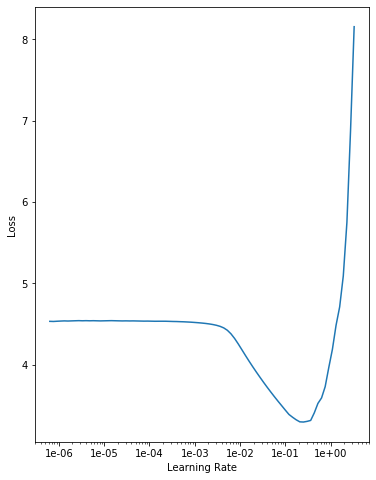

In [51]:
# find a good learning rate
learner.lr_find()
learner.recorder.plot()

In [52]:
# train for a few epochs, this is not long enough for the model to converge.
learner.fit_one_cycle(2, 1e-1)
learner.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.599195,1.836529,0.678152,00:18
1,0.893318,0.855686,0.704532,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.650017,0.573683,0.801087,00:18
1,0.456792,0.443417,0.825210,00:18
2,0.406872,0.403760,0.837987,00:18
3,0.395653,0.390303,0.840258,00:18
4,0.372606,0.368304,0.849665,00:18


In [16]:
# see what the post training output looks like
test_sample(learner, DatasetType.Valid, 27)

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>1441-01-23<eos>


### Define some helper functions to evaluate and visualize the model's output

In [17]:
def make_predictions(learner, ds_type):
    learner.model.eval()
    dl = learner.data.dl(ds_type)
    df = dl.dataset.df
    preds = []
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            _, pred_labels = learner.model.predict(xb['encode_text'])
            pred_tokens = [decode_tensor(x, int_to_tok, strip_pad=True) for x in pred_labels]
            preds += [''.join(pred) for pred in pred_tokens]
        df['predicted'] = preds
    return df


def eval_df(df) -> float:
    preds = df['predicted'].apply(lambda x: x.rstrip('<eos>').strip('<sos>'))
    perfect = df['output'] == preds
    df['correct'] = perfect
    pct_perfect = perfect.mean()
    return pct_perfect * 100


def decode_text(learner, text: str):
    encode_text = learner.data.valid_ds.get_tokens(text, 'pre').unsqueeze(0)
    encode_text = encode_text.to(learner.data.device)
    learner.model.eval()
    with torch.no_grad():
        _, pred_labels = learner.model.predict(encode_text)
    tokens = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    return ''.join(tokens)


def display_prediction(learner, text: str):
    pred = decode_text(learner, text)
    html_str = '<hr>'
    html_str += f'<font size="5">{text} &rarr; {pred}</font>'
    html_str += '<hr>'
    display(HTML(html_str))

### Visualize the output

In [18]:
display_prediction(learner, 'December 25 1991')

In [19]:
train_df = make_predictions(learner, DatasetType.Fix)
valid_df = make_predictions(learner, DatasetType.Valid)
test_df = make_predictions(learner, DatasetType.Test)

In [20]:
print('** Perfect transcriptions **')
print(f'Train accuracy: {eval_df(train_df):0.2f}%')
print(f'Valid accuracy: {eval_df(valid_df):0.2f}%')
print(f'Test accuracy: {eval_df(test_df):0.2f}%')

** Perfect transcriptions **
Train accuracy: 3.46%
Valid accuracy: 3.23%
Test accuracy: 3.68%


In [21]:
valid_df.sample(8)[['input', 'output', 'predicted']]

,input,output,predicted
6635,"Oct 20, 1700",1700-10-20,<sos>1400-10-20<eos>
1522,7/17/1533,1533-07-17,<sos>1533-08-15<eos>
6019,"Thursday January 21, 1644",1644-01-21,<sos>1444-01-21<eos>
5744,"May 6, 17",1817-05-06,<sos>1916-03-06<eos>
6298,Feb 3 1865,1865-02-03,<sos>1465-03-03<eos>
1671,"January 4, 1751",1751-01-04,<sos>1451-01-07<eos>
1711,"May 24, 2078",2078-05-24,<sos>2048-03-27<eos>
5833,1448/7/1,1448-07-01,<sos>1445-04-01<eos>


# 3. Seq2Seq w/ Luong Attention

https://arxiv.org/pdf/1508.04025.pdf

This is an implementation of Luong's attention. This is just one way of implementing attention. There are many methods, but this one requires the fewest number of parameters.

![Luong Figure 2.](img/luong_attn.png)

### Attention Motivation
TLDR; A single fixed-length vector can not store an infinite amount of information.

The challenge in vanilla Seq2Seq is that a lot of information is lost between the encoder and decoder. This is seen as a single fixed-length vector (the encoder's last hidden state) being passed to the decoder. This forces the decoder to translate the encoded message with degraded information.

A better approach is to pass the entire encoded sequence to the decoder, guaranteeing no information loss. In practice this is seen as the sequence of hidden states from the encoder.

The attention mechanism allows you to "focus" on a particular peice of context given a query. This is commonly seen in neural machine translation (NMT). In NMT, the "context" is set by the encoder.

### Implementation:
1. Encode the input text, you will get 1 vector for each step in the input. This tensor will have shape (batch, timesteps, dim)
2. Keep all of the encoder's hidden states, call this $\bar{H}$ where $\bar{h}_t$ is the encoder's hidden state for time step $t$.
4. Initialize the decoder's context state with zeros, $c_0$.
5. Concatenate the decoder's input (starting with "<sos\>") with $c_0$ and pass this to the decoder's rnn.
6. Take the RNN's current hidden state, call this $h_t$, and dot it with each $\bar{h}_t$. This will yield an attention score for each encoder timestep. Take the softmax across the scores and call this $a$. The values in $a$, $a_t$, are the amount of "focus" the decoder is putting on each timestep of the encoder.
7. Take the sum of $\bar{H}$ weighted by $a$. 
$$c_t=\sum_{t}{a_t * \bar{h}_t}$$
This is the context vector, $c_t$, which tells your decoder what parts of the encoded sequence are important.
8. Concat $c_t$ and $h_t$, and pass through a dense layer to make your prediction.

#### The attention mechanism

In [22]:
def attention(
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor = None,
        mask: torch.Tensor = None,
        dropout_rate: float = 0.0,
        scale: bool = False,
        training: bool = False,
    ) -> Tuple[torch.Tensor]:
    """Compute attention weights and values.

    A combination of the value tensor for each time step in query.

    Attention weights are computed via dot product.

    Parameters
    ----------
    query : torch.Tensor
        shape (batch_size, Tq, dim)
    key : torch.Tensor
        shape (batch_size, Tv, dim)
    value : torch.Tensor
        shape (batch_size, Tv, dim), by default None will use `key` tensor
    mask : torch.Tensor, optional
        Shape must be broadcastable to (batch_size, Tq, Tv), by default None
    dropout_rate: float, optional
        apply dropout to attention scores before softmax, by default 0.0
    scale : bool, optional
        scale the attention scores by 1./sqrt(dim), by default False
        Introduced in Eq. 1 Vaswani et al.
    training: bool, optional
        training or evaluation mode, set by passing `model.training`, by default False

    Returns
    -------
    Tuple[torch.Tensor]
        A linear combination of the value tensor for each time step in query.
    """
    if value is None: value = key
    B, Tq, dim = query.size()
    Tv = value.size(1)
    # Section 3.1 Global Attention -> "dot"
    attn_scores = torch.bmm(query, torch.transpose(key, 1, 2))  #  (B, Tq, Tv)
    attn_scores = F.dropout(attn_scores, dropout_rate, training, False)  # (B, Tq, Tv)
    if scale:
        attn_scores /= math.sqrt(dim)
    if mask is not None:
        attn_scores -= (mask * 1e9)
    attn_weights = F.softmax(attn_scores, dim=-1)  #  Eq. 8, (B, Tq, Tv)
    output = torch.bmm(attn_weights, value)  # (B, Tq, e)
    return output, attn_weights

### Seq2Seq w/ Luong Attention

In [23]:
# Nothing changes on the encoder

class AttnSequenceDecoder(nn.Module):
    def __init__(self, tok_to_int: dict, scale: bool = False) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS
        self.scale_attn = scale
        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            2*self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first = False
        )
        self.h_tilda = nn.Sequential(
            nn.Linear(2 * self.hidden_size, self.hidden_size),
            nn.Tanh()
        )  # Eq. 5
        self.densor = nn.Linear(self.hidden_size, self.vocab_size)  # Eq. 6, without the softmax

    def apply_attention(self, X: torch.FloatTensor, encoder_output: torch.FloatTensor, encoder_mask: torch.Tensor):
        encoder_output = torch.transpose(encoder_output, 0, 1)  # (B, Tv, e)
        context, attn_weights = attention(
            query=X,
            key=encoder_output,
            value=encoder_output,
            mask=encoder_mask.unsqueeze(1),  # (B, 1, Tv)
            dropout_rate=0.,
            scale=self.scale_attn,
            training=self.training
        )  # (B, Tq, e), (B, Tq, Tv)
        return context, attn_weights
    
    def forward_onestep(
        self, 
        X: torch.LongTensor,
        state: Tuple[torch.Tensor],
        context: torch.FloatTensor, 
        encoder_output: torch.FloatTensor,
        encoder_mask: torch.Tensor
    ) -> Tuple[torch.Tensor]:
        assert X.size(1) == 1
        B = X.size(0)
        emb = self.embedding_layer(X)  # (B, 1, e)
        emb = torch.cat([emb, context], dim=2)  # (B, 1, 2e)
        emb_t = torch.transpose(emb, 0, 1)  # (1, B, 2e)
        emb_t, state = self.rnn(emb_t, state)  # (1, B, e)
        emb = torch.transpose(emb_t, 0, 1)  # (B, 1, e)
        context, attn_weights = self.apply_attention(emb, encoder_output, encoder_mask)  # (B, 1, e), (B, 1, Tv)
        
        # Figure 4, "Attentional vectors h_tilda are fed as inputs to the next time steps"
        h = torch.cat([emb, context], dim=2)
        next_context = self.h_tilda(h)  # (B, 1, e)
        logit = self.densor(next_context)  # (B, 1, vocab_size)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob, next_context, state, attn_weights

    def forward(
        self, 
        X: torch.LongTensor,
        state: Tuple[torch.Tensor],
        context: torch.FloatTensor, 
        encoder_output: torch.FloatTensor,
        encoder_mask: torch.Tensor
    ) -> Tuple[torch.Tensor]:
        
        log_probs = []
        attn_weights = []
        for i in range(X.size(1)):
            Xt = X[:, i:i+1]
            log_prob, context, state, attn = self.forward_onestep(
                Xt,
                state,
                context,
                encoder_output,
                encoder_mask
            )
            log_probs.append(log_prob)
            attn_weights.append(attn)
        log_probs = torch.cat(log_probs, dim=1)
        attn_weights = torch.cat(attn_weights, dim=1)
        return log_probs, state, attn_weights

    def _init_hidden(self, batch_size: int) -> Tuple[torch.FloatTensor]:
        h = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        if isinstance(self.rnn, nn.RNN):
            return h.to(self.device)
        c = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        return [h.to(self.device), c.to(self.device)]
    
    def _init_context(self, batch_size: int) -> torch.FloatTensor:
        c = torch.zeros(batch_size, 1, self.hidden_size)
        return c.to(self.device)

    def get_mask(self, X):
        return (X == 0).float()

    @property
    def device(self):
        return list(self.parameters())[0].device


class AttnSeq2Seq(nn.Module):
    def __init__(self, tok_to_int: dict, scale: bool = False) -> None:
        super().__init__()
        self.tok_to_int = tok_to_int
        self.encoder = SequenceEncoder(tok_to_int)
        self.decoder = AttnSequenceDecoder(tok_to_int, scale)

    def forward(self, X: dict):
        teacher_force = random.random() < 0.5
        if teacher_force:
            B = X['encode_text'].size(0)
            encoder_mask = self.encoder.get_mask(X['encode_text'])
            encoder_out, encoder_state = self.encoder(X['encode_text'])
            state, context = self.decoder._init_hidden(B), self.decoder._init_context(B)
            log_prob, decoder_state, attn_weights = self.decoder(
                X['decode_text'], state, context, encoder_out, encoder_mask
            )  # (B, T, e), ...
        else:
            log_prob, decoder_text, attn_weights = self.predict(X['encode_text'])
        return log_prob.view(-1, self.decoder.vocab_size)

    def predict(self, encode_text):
        B, Tv = encode_text.size(0), encode_text.size(1)
        encoder_out, encoder_state = self.encoder(encode_text)
        encoder_mask = self.encoder.get_mask(encode_text)
        decoder_text = self._init_decode_text(B)
        state, context = self.decoder._init_hidden(B), self.decoder._init_context(B)
        log_probs = []  # keep track of log probs for each timestep
        attn_weights = [torch.zeros(B, 1, Tv).to(self.device)]  # keep track of the attn weights for each timestep
        for i in range(_MAXLEN - 1):
            Xt = decoder_text[:, i:i+1]
            log_prob, context, state, attn = self.decoder.forward_onestep(
                Xt, state, context, encoder_out, encoder_mask
            )  # (B, 1, vocab_size), ...
            log_probs.append(log_prob)
            attn_weights.append(attn)
            token_pred = log_prob.argmax(dim=-1)  # (B, 1)
            decoder_text = torch.cat([decoder_text, token_pred], dim=1)
        attn_weights = torch.cat(attn_weights, dim=1)  # (B, T, T)
        log_probs = torch.cat(log_probs, dim=1)  # (B, T, e), log probs for each time step
        return log_probs, decoder_text, attn_weights

    def _predict_one_step(self, decoder_text, state, encoder_output, encoder_mask):
        assert decoder_text.size(1) == 1
        decoder_out, decoder_state, attn_weights = self.decoder(decoder_text, state, encoder_output, encoder_mask)
        return decoder_out, decoder_state, attn_weights

    def _init_decode_text(self, batch_size: int) -> torch.LongTensor:
        sos = torch.zeros(batch_size, 1, dtype=torch.int64).to(self.decoder.device)
        sos += 2
        return sos
    
    @property
    def device(self):
        return list(self.parameters())[0].device

In [24]:
def test_sample(learner, ds_type, idx):
    ds = learner.data.dl(ds_type).dataset
    sample = ds.df.iloc[idx]
    data = ds[idx]
    xb, yb = learner.data.collate_fn([data])
    xb = {k: v.to(learner.data.device) for k, v in xb.items()}
    with torch.no_grad():
        log_prob, pred_labels, attn = learner.model.predict(xb['encode_text'])
        attn = attn[0]
    toks = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    decode_text = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    encode_text = decode_tensor(xb['encode_text'][0], int_to_tok, strip_pad=True)
    imshow_attn(attn, encode_text, decode_text)
    print('Input:', sample.input)
    print('Expected Output:', sample.output)
    print('Predicted Output:', decoded)
    return attn

def imshow_attn(attn: torch.FloatTensor, encode_text, decode_text):
    ne, nd = len(encode_text), len(decode_text)
    attn_vals = attn.cpu().numpy()[0:nd, -ne:].T
    plt.imshow(attn_vals, cmap='gray', vmin=0., vmax=1.)
    plt.colorbar()
    plt.yticks(np.arange(len(encode_text)), encode_text)
    plt.xticks(np.arange(len(decode_text)), decode_text, rotation=45)
    plt.xlabel('Output Text')
    plt.ylabel('Input text')
    plt.show()

## Train the seq2seq w/ attention model

In [25]:
model = AttnSeq2Seq(tok_to_int, scale=False).to(data.device)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

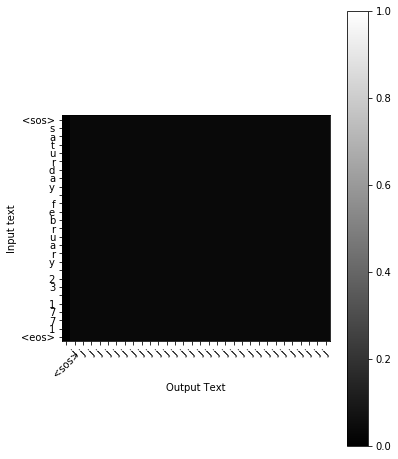

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj


In [26]:
# see what the initial output and attention values look like
attn = test_sample(learner, DatasetType.Valid, 27)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


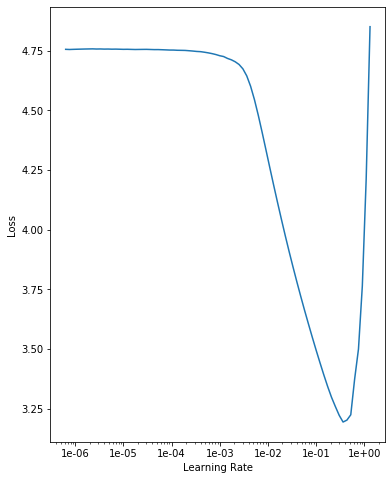

In [27]:
learner.lr_find()
learner.recorder.plot()

In [28]:
learner.fit_one_cycle(2, 1e-2)
learner.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.524189,0.455133,0.826177,00:28
1,0.424146,0.422143,0.828610,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.401535,0.399873,0.834929,00:27
1,0.355007,0.348812,0.848045,00:27
2,0.306041,0.297662,0.880803,00:27
3,0.227135,0.214975,0.921690,00:27
4,0.121401,0.106299,0.976655,00:28


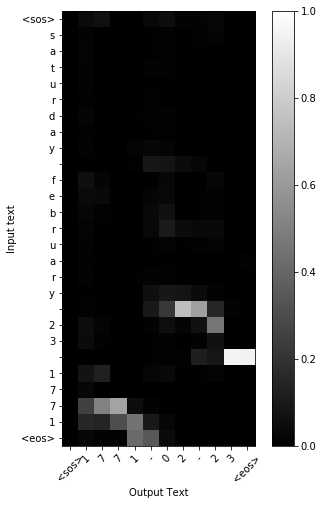

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>1771-02-23<eos>


In [29]:
# see what the post training output looks like
attn = test_sample(learner, DatasetType.Valid, 27)

### Visualize some output

In [38]:
def make_predictions_attn(learner, ds_type):
    learner.model.eval()
    dl = learner.data.dl(ds_type)
    df = dl.dataset.df
    preds = []
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            _, pred_labels, _ = learner.model.predict(xb['encode_text'])
            pred_tokens = [decode_tensor(x, int_to_tok, strip_pad=True) for x in pred_labels]
            preds += [''.join(pred) for pred in pred_tokens]
        df['predicted_w_attn'] = preds
    return df

def eval_df(df) -> float:
    preds = df['predicted_w_attn'].apply(lambda x: x.rstrip('<eos>').strip('<sos>'))
    perfect = df['output'] == preds
    df['correct'] = perfect
    pct_perfect = perfect.mean()
    return pct_perfect * 100

def decode_text(learner, text: str):
    encode_text = learner.data.valid_ds.get_tokens(text, 'pre').unsqueeze(0)
    encode_text = encode_text.to(learner.data.device)
    learner.model.eval()
    with torch.no_grad():
        log_probs, pred_labels, attn = learner.model.predict(encode_text)
        attn = attn[0]
        pred_labels = pred_labels[0]
    toks = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    decode_text = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    encode_text = decode_tensor(encode_text[0], int_to_tok, strip_pad=True)
    imshow_attn(attn, encode_text, decode_text)
    tokens = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    return ''.join(tokens)


def display_prediction(learner, text: str):
    pred = decode_text(learner, text)
    html_str = '<hr>'
    html_str += f'<font size="5">{text} &rarr; {pred}</font>'
    html_str += '<hr>'
    display(HTML(html_str))

In [36]:
train_df = make_predictions_attn(learner, DatasetType.Fix)
valid_df = make_predictions_attn(learner, DatasetType.Valid)
test_df = make_predictions_attn(learner, DatasetType.Test)

In [39]:
print('** Perfect transcriptions **')
print(f'Train accuracy: {eval_df(train_df):0.2f}%')
print(f'Valid accuracy: {eval_df(valid_df):0.2f}%')
print(f'Test accuracy: {eval_df(test_df):0.2f}%')

** Perfect transcriptions **
Train accuracy: 47.42%
Valid accuracy: 48.32%
Test accuracy: 47.96%


In [41]:
valid_df.sample(8)[['input', 'output', 'predicted', 'predicted_w_attn']]

,input,output,predicted,predicted_w_attn
9191,"Nov 1, 31",1731-11-01,<sos>1411-11-01<eos>,<sos>1531-11-01<eos>
6457,1513/7/16,1513-07-16,<sos>1913-04-17<eos>,<sos>1513-07-16<eos>
3771,June 25 1958,1958-06-25,<sos>1955-04-27<eos>,<sos>1958-06-25<eos>
1457,January 21 1818,1818-01-21,<sos>1418-01-21<eos>,<sos>1818-01-21<eos>
9642,"Saturday May 11, 1422",1422-05-11,<sos>1422-03-13<eos>,<sos>1622-05-11<eos>
5974,12-22-1663,1663-12-22,<sos>1443-01-22<eos>,<sos>2063-12-22<eos>
7800,19-4-1761,1761-04-19,<sos>1441-04-15<eos>,<sos>1761-04-19<eos>
1140,"June 26, 2071",2071-06-26,<sos>2041-09-29<eos>,<sos>2071-06-26<eos>


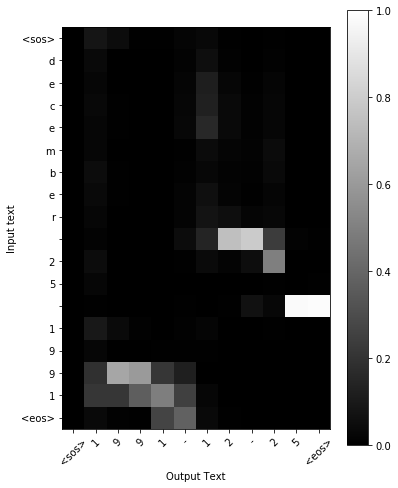

In [31]:
display_prediction(learner, 'December 25 1991')

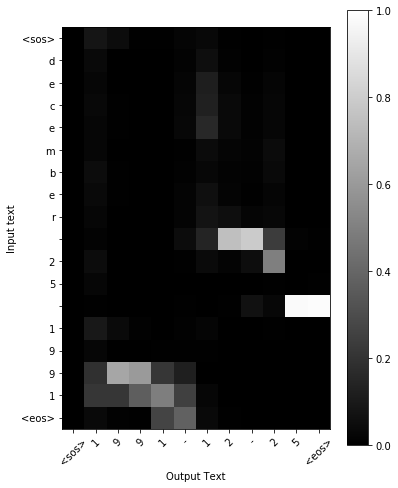

In [32]:
display_prediction(learner, 'december 25 1991')

## 4. Attention Freestyle Notes

There are many ways to implement an attention mechanism, but they all have one thing in common. Each maps a query vector and a set of key vectors to a softmax over some combination of the query and key.

A few popular ways of getting this softmax are Luong, Bahdanau, and mutliheaded.

In the Luong implementation, attention is applied after the RNN, but you are not forced to do so. You may want to see what happens if you apply attention before the RNN layer.

**Caution:** Since there are several valid ways to implement attention, there are a number of references that get it wrong. The most common mistake I have seen is a model's size scaling with the input/output sequence length.